In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZQk37k1UUUiZ03xNP3Bz")
project = rf.workspace("brad-dwyer").project("wildfire-smoke")
version = project.version(1)
dataset = version.download("tfrecord")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Wildfire-Smoke-1 in tfrecord:: 100%|██████████| 8/8 [00:00<00:00, 111.38it/s]


In [ ]:
# # Load label map
# label_map = {}
# with open(train_label_map_path, "r") as f:
#     lines = f.readlines()
#     class_id = None
#     class_name = None
#     for line in lines:
#         if "id" in line:
#             id = int(line.split(":")[1].strip())
#         elif "name" in line:
#             class_name = line.split(":")[1].strip().replace("'", "")
#         if class_id is not None and class_name is not None:
#             label_map[class_id] = class_name
#             class_id = None
#             class_name = None


NameError: name 'train_label_map_path' is not defined

In [ ]:
!ls /content/Wildfire-Smoke-1

README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Paths to your TFRecord files and label map
train_tfrecord_path = "/content/Wildfire-Smoke-1/train/Smoke.tfrecord"
train_label_map_path = "/content/Wildfire-Smoke-1/train/Smoke_label_map.pbtxt"

validation_tfrecord_path = "/content/Wildfire-Smoke-1/valid/Smoke.tfrecord"
validation_label_map_path = "/content/Wildfire-Smoke-1/valid/Smoke_label_map.pbtxt"

test_tfrecord_path = "/content/Wildfire-Smoke-1/test/Smoke.tfrecord"
test_label_map_path = "/content/Wildfire-Smoke-1/test/Smoke_label_map.pbtxt"

# Load label map
label_map = {}
with open(train_label_map_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        if "id" in line:
            class_id = int(line.split(":")[-1].strip().rstrip(','))
        elif "name" in line:
            class_name = line.split(":")[-1].strip().replace('"', '')
            label_map[class_id] = class_name

# Load TFRecord datasets
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, (300, 300))
    label = example['image/object/class/label']
    return image, label

batch_size = 32  # Choose an appropriate batch size

train_dataset = tf.data.TFRecordDataset(train_tfrecord_path)
train_dataset = train_dataset.map(parse_tfrecord_fn).batch(batch_size)

validation_dataset = tf.data.TFRecordDataset(validation_tfrecord_path)
validation_dataset = validation_dataset.map(parse_tfrecord_fn).batch(batch_size)

test_dataset = tf.data.TFRecordDataset(test_tfrecord_path)
test_dataset = test_dataset.map(parse_tfrecord_fn).batch(batch_size)

# Define the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(len(label_map), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy', Precision(), Recall()])

# Train the model
model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


Epoch 1/10
17/17 [==============================] - 63s 4s/step - loss: 0.3705 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 0.0156 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 2/10
17/17 [==============================] - 58s 3s/step - loss: 0.0073 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/10
17/17 [==============================] - 47s 3s/step - loss: 0.0027 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 4/10
17/17 [==============================] - 47s 3s/step - loss: 0.0021 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 5/10
17/17 [==============================] - 57s 3s/step - loss: 0.0018 -

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

def draw_bounding_boxes(image, boxes, class_ids, label_map):
    image_with_boxes = np.array(image, dtype=np.uint8)
    for box, class_id in zip(boxes, class_ids):
        xmin, ymin, xmax, ymax = box
        xmin = int(xmin * image.shape[1])
        ymin = int(ymin * image.shape[0])
        xmax = int(xmax * image.shape[1])
        ymax = int(ymax * image.shape[0])
        color = (0, 255, 0) if label_map[class_id] == "smoke" else (255, 0, 0)
        cv2.rectangle(image_with_boxes, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(image_with_boxes, label_map[class_id], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image_with_boxes

# Load label map
label_map = {}
with open(train_label_map_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        if "id" in line:
            class_id = int(line.split(":")[-1].strip().rstrip(','))
        elif "name" in line:
            class_name = line.split(":")[-1].strip().replace('"', '')
            label_map[class_id] = class_name

# Perform inference on test dataset and draw bounding boxes
for images, labels in test_dataset.take(1):  # Take one batch for demonstration
    predictions = model.predict(images)
    class_ids = np.argmax(predictions, axis=1)
    images = images.numpy()  # Convert images to NumPy array
    labels = labels.numpy()  # Convert labels to NumPy array
    for image, label in zip(images, labels):  # Iterate through each image and label in the batch
        image_with_boxes = draw_bounding_boxes(image, [label], [class_ids], label_map)
        cv2.imshow("Image with Bounding Boxes", image_with_boxes)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


NameError: name 'train_label_map_path' is not defined

In [ ]:
import tensorflow as tf

# Paths to your TFRecord files and label map
train_tfrecord_path = "/content/Wildfire-Smoke-1/train/Smoke.tfrecord"
train_label_map_path = "/content/Wildfire-Smoke-1/train/Smoke_label_map.pbtxt"

# Load label map
label_map = {}
with open(train_label_map_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        if "id" in line:
            class_id = int(line.split(":")[-1].strip().rstrip(','))
        elif "name" in line:
            class_name = line.split(":")[-1].strip().replace('"', '')
            label_map[class_id] = class_name

# Load TFRecord datase
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    label = example['image/object/class/label']
    return label

dataset = tf.data.TFRecordDataset(train_tfrecord_path)
dataset = dataset.map(parse_tfrecord_fn)

# Print some information about the dataset
for example in dataset.take(5):  # Take 5 examples for demonstration
    print("Label:", example.numpy())


Label: 1
Label: 1
Label: 1
Label: 1
Label: 1


AttributeError: 'numpy.int64' object has no attribute 'numpy'

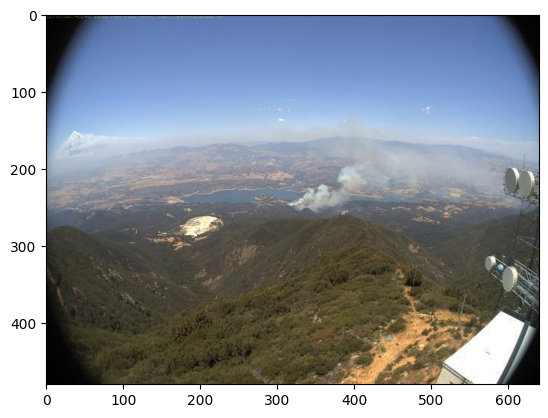

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load label map
label_map = {1: 'smoke'}  # Assuming smoke label is assigned the class ID 1

# Function to parse TFRecord and extract image and bounding box
def parse_tfrecord_for_display(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    label = example['image/object/class/label']
    xmin = example['image/object/bbox/xmin']
    ymin = example['image/object/bbox/ymin']
    xmax = example['image/object/bbox/xmax']
    ymax = example['image/object/bbox/ymax']
    return image, label, (xmin, ymin, xmax, ymax)

# Load a sample image and its bounding box from the TFRecord file
def load_sample_image_with_bbox(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_for_display)
    for image, label, bbox in dataset.take(1):
        return image.numpy(), label.numpy(), bbox  # **Changes highlighted**

# Display image with bounding box
def display_image_with_boxes(image, bounding_box, label):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    xmin, ymin, xmax, ymax = bounding_box
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 2, label_map[label.numpy()], color='r')  # **Changes highlighted**
    plt.show()

# Choose dataset path
dataset_path = "/content/Wildfire-Smoke-1/train/Smoke.tfrecord"  # Change this to your desired dataset

# Load a sample image and its bounding box
image, label, bounding_box = load_sample_image_with_bbox(dataset_path)

# Display the image with bounding box
display_image_with_boxes(image, bounding_box, label)


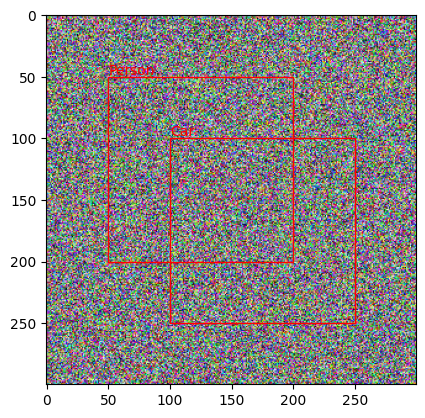

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display image with bounding boxes
def display_image_with_boxes(image, bounding_boxes, labels):
    """
    image: numpy array, the input image
    bounding_boxes: list of tuples, each tuple containing (xmin, ymin, xmax, ymax)
    labels: list of strings, containing the labels corresponding to each bounding box
    """
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Add bounding boxes to the image
    for bbox, label in zip(bounding_boxes, labels):
        xmin, ymin, xmax, ymax = bbox
        # Calculate width and height of the bounding box
        width = xmax - xmin
        height = ymax - ymin

        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add label text
        ax.text(xmin, ymin - 2, label, color='r')

    # Show the plot
    plt.show()

# Example usage:
image = np.random.rand(300, 300, 3)  # Example random image
bounding_boxes = [(50, 50, 200, 200), (100, 100, 250, 250)]  # Example bounding boxes
labels = ['Person', 'Car']  # Example labels corresponding to each bounding box

# Display the image with bounding boxes
display_image_with_boxes(image, bounding_boxes, labels)


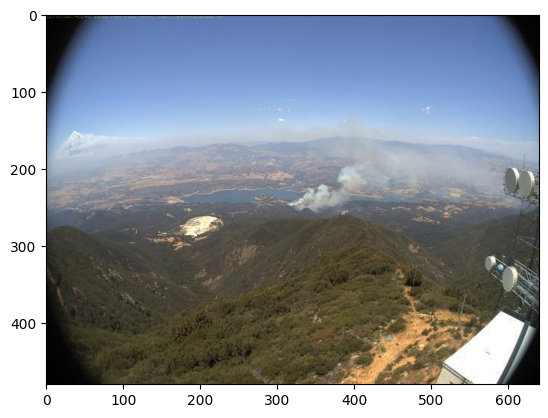

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load label map
label_map = {1: 'smoke'}  # Assuming smoke label is assigned the class ID 1

# Function to parse TFRecord and extract image and bounding box
def parse_tfrecord_for_display(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    label = example['image/object/class/label']
    xmin = example['image/object/bbox/xmin']
    ymin = example['image/object/bbox/ymin']
    xmax = example['image/object/bbox/xmax']
    ymax = example['image/object/bbox/ymax']
    return image, label, (xmin, ymin, xmax, ymax)

# Load a sample image and its bounding box from the TFRecord file
def load_sample_image_with_bbox(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_for_display)
    for image, label, bbox in dataset.take(1):
        return image.numpy(), label, bbox  # Removed .numpy() from label and bbox

# Display image with bounding box
def display_image_with_boxes(image, bounding_box, label):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    xmin, ymin, xmax, ymax = bounding_box
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 2, label_map[label.numpy()], color='r')  # Added .numpy() to label here
    plt.show()

# Choose dataset path
dataset_path = "/content/Wildfire-Smoke-1/train/Smoke.tfrecord"  # Change this to your desired dataset

# Load a sample image and its bounding box
image, label, bounding_box = load_sample_image_with_bbox(dataset_path)

# Apply bounding box to the image
image_with_bbox = np.array(image)  # Convert image to NumPy array
xmin, ymin, xmax, ymax = bounding_box
xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
cv2.rectangle(image_with_bbox, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Display the image with bounding box
plt.imshow(image_with_bbox)
plt.show()


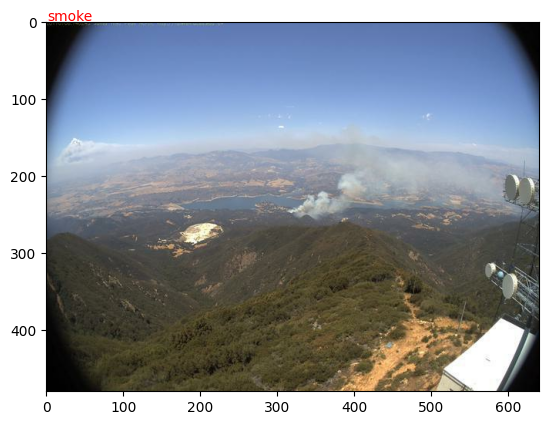

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load label map
label_map = {1: 'smoke'}  # Assuming smoke label is assigned the class ID 1

# Function to parse TFRecord and extract image and bounding box
def parse_tfrecord_for_display(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    label = example['image/object/class/label']
    xmin = example['image/object/bbox/xmin']
    ymin = example['image/object/bbox/ymin']
    xmax = example['image/object/bbox/xmax']
    ymax = example['image/object/bbox/ymax']
    return image, label, (xmin, ymin, xmax, ymax)

# Load a sample image and its bounding box from the TFRecord file
def load_sample_image_with_bbox(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_for_display)
    for image, label, bbox in dataset.take(1):
        return image.numpy(), label.numpy(), bbox  # Now convert all to NumPy arrays

# Display image with bounding box
def display_image_with_boxes(image, bounding_box, label):
    fig, ax = plt.subplots(1)
    ax.imshow(image)  # Ensure image is converted to NumPy array before plotting
    xmin, ymin, xmax, ymax = bounding_box
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 2, label_map[label], color='r')
    plt.show()

# Choose dataset path
dataset_path = "/content/Wildfire-Smoke-1/train/Smoke.tfrecord"  # Change to your dataset

# Load a sample image and its bounding box
image, label, bounding_box = load_sample_image_with_bbox(dataset_path)

# Display the image with bounding box
display_image_with_boxes(image, bounding_box, label)


In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import numpy as np

# # Load label map
# label_map = {1: 'smoke'}  # Assuming smoke label is assigned the class ID 1

# # Function to parse TFRecord and extract image and bounding box
# def parse_tfrecord_for_display(example):
#     feature_description = {
#         'image/encoded': tf.io.FixedLenFeature([], tf.string),
#         'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
#         'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
#         'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
#         'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32)
#     }
#     example = tf.io.parse_single_example(example, feature_description)

#     # **Key change: Evaluate tensors within a tf.function context**
#     @tf.function
#     def decode_and_convert(image_data, label, xmin, ymin, xmax, ymax):
#         image = tf.image.decode_jpeg(image_data, channels=3)
#         return image, label.numpy(), (xmin.numpy(), ymin.numpy(), xmax.numpy(), ymax.numpy())

#     image, label, bounding_box = decode_and_convert(
#         example['image/encoded'],
#         example['image/object/class/label'],
#         example['image/object/bbox/xmin'],
#         example['image/object/bbox/ymin'],
#         example['image/object/bbox/xmax'],
#         example['image/object/bbox/ymax'])

#     return image, label, bounding_box

# # Load a sample image and its bounding box from the TFRecord file
# def load_sample_image_with_bbox(tfrecord_path):
#     dataset = tf.data.TFRecordDataset(tfrecord_path)
#     dataset = dataset.map(parse_tfrecord_for_display)
#     return next(iter(dataset))  # Efficient extraction using iterator

# # Display image with bounding box
# def display_image_with_boxes(image, bounding_box, label, thickness=2, color='r'):
#     """
#     Displays an image with a bounding box and label.

#     Args:
#         image: A NumPy array representing the image.
#         bounding_box: A tuple of four elements (xmin, ymin, xmax, ymax) representing the bounding box coordinates.
#         label: The label of the object in the bounding box.
#         thickness: The thickness of the bounding box line (default: 2).
#         color: The color of the bounding box line (default: 'r' for red).
#     """
#     fig, ax = plt.subplots(1)
#     ax.imshow(image)
#     xmin, ymin, xmax, ymax = bounding_box
#     width = xmax - xmin
#     height = ymax - ymin
#     rect = plt.Rectangle((xmin, ymin), width, height, linewidth=thickness, edgecolor=color, facecolor='none')
#     ax.add_patch(rect)
#     ax.text(xmin, ymin - 2, label, color=color, fontsize=12)  # Added label text
#     plt.show()

# # Choose dataset path
# dataset_path = "/content/Wildfire-Smoke-1/train/Smoke.tfrecord"  # Change this to your desired dataset

# # Load a sample image and its bounding box
# image, label, bounding_box = load_sample_image_with_bbox(dataset_path)

# # Display the image with bounding box
# display_image_with_boxes(image, bounding_box, label_map[label])


AttributeError: in user code:

    File "<ipython-input-24-c1496d0ff0fa>", line 24, in decode_and_convert  *
        return image, label.numpy(), (xmin.numpy(), ymin.numpy(), xmax.numpy(), ymax.numpy())

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow.compat.v1 as tf


# tf.config.set_global_option(tf.compat.v1.InteractiveSession())



# # Load label map
# label_map = {1: 'smoke'}  # Assuming smoke label is assigned the class ID 1

# # Function to parse TFRecord and extract image and bounding box
# def parse_tfrecord_for_display(example):
#     feature_description = {
#         'image/encoded': tf.io.FixedLenFeature([], tf.string),
#         'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
#         'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
#         'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
#         'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32)
#     }
#     example = tf.io.parse_single_example(example, feature_description)
#     image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
#     label = example['image/object/class/label']
#     xmin = example['image/object/bbox/xmin'].numpy()  # Ensure numpy conversion here
#     ymin = example['image/object/bbox/ymin'].numpy()
#     xmax = example['image/object/bbox/xmax'].numpy()
#     ymax = example['image/object/bbox/ymax'].numpy()
#     return image, label.numpy(), (xmin, ymin, xmax, ymax)  # Consistent numpy usage

# # Load a sample image and its bounding box from the TFRecord file
# def load_sample_image_with_bbox(tfrecord_path):
#     dataset = tf.data.TFRecordDataset(tfrecord_path)
#     dataset = dataset.map(parse_tfrecord_for_display)
#     return next(iter(dataset))  # Efficient extraction using iterator

# # Display image with bounding box
# def display_image_with_boxes(image, bounding_box, label):
#     fig, ax = plt.subplots(1)
#     ax.imshow(image)
#     xmin, ymin, xmax, ymax = bounding_box
#     width = xmax - xmin
#     height = ymax - ymin
#     rect = plt.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     ax.text(xmin, ymin - 2, label_map[label], color='r')  # Use label directly as it's already a string
#     plt.show()

# # Choose dataset path
# dataset_path = "/content/Wildfire-Smoke-1/train/Smoke.tfrecord"  # Change this to your desired dataset

# # Load a sample image and its bounding box
# image, label, bounding_box = load_sample_image_with_bbox(dataset_path)

# # Display the image with bounding box
# display_image_with_boxes(image, bounding_box, label)


AttributeError: module 'tensorflow._api.v2.compat.v1.config' has no attribute 'set_global_option'

In [ ]:
from google.colab.patches import cv2_imshow